In [1]:
import toml
import sys
sys.path = ["/g/data/x77/ahg157/python-ale/build/lib.linux-x86_64-cpython-39"] + sys.path
import pyale
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cm
import os
os.environ["OMP_NUM_THREADS"] = str(28)  ## make this match the cores available!

## Load grid information into dataset

In [2]:
ds = xr.open_dataset('/scratch/x77/amh157/mom6/archive/zstar/output300/ocean_static.nc')

In [3]:
restart_filename = '/scratch/x77/amh157/mom6/archive/zstar/restart300/MOM.res.nc'
ds2 = xr.open_dataset(restart_filename)

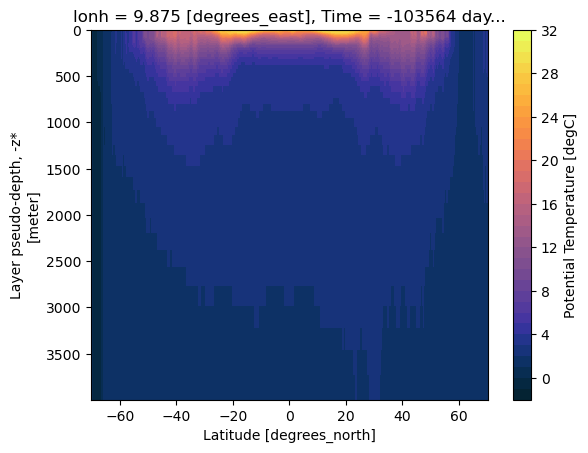

In [4]:
vlev = np.linspace(-2,32,35)
ds2.Temp.isel(Time=0).isel(lonh=39).plot(levels=vlev,cmap=cm.cm.thermal)
plt.gca().invert_yaxis()

## Load Standard Adaptive Params

In [5]:
params = toml.load("/g/data/x77/amh157/anu-tub/diagnostics/params_adapt.toml")
cs = pyale.mom_init_cs(params)

 log_version: MOM_domains                             , unknown
 MOM_domains                              REENTRANT_X:  T
 MOM_domains                              REENTRANT_Y:  F
 MOM_domains                              TRIPOLAR_N:  F
 MOM_domains                              OCEAN_OMP_THREADS:            1
 MOM_domains                              OCEAN_OMP_HYPER_THREAD:  F
 MOM_domains                              !SYMMETRIC_MEMORY_:  T
 MOM_domains                              NONBLOCKING_UPDATES:  F
 MOM_domains                              THIN_HALO_UPDATES:  T
 MOM_domains                              !STATIC_MEMORY_:  F
 MOM_domains                              NIGLOBAL:          160
 MOM_domains                              NJGLOBAL:          800
 MOM_domains                              NIHALO:            4
 MOM_domains                              NJHALO:            4
 MOM_domains                              MASKTABLE: 'MOM_mask_table'
 MOM_domains                         

In [6]:
%%time
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "ADAPTIVE")
(h, temp, salt) = pyale.accelerate_ale(cs, adapt_cs, iter=20, dt=3600)

CPU times: user 2min 8s, sys: 10.5 s, total: 2min 19s
Wall time: 2min 13s
 init_MOM_state INPUTDIR: '/g/data/x77/amh157/mom6/input/anu-tub'
 init_MOM_state REGRIDDING_COORDINATE_UNITS: 'm'
 init_MOM_state INTERPOLATION_SCHEME: 'P1M_H2'
 init_MOM_state DEFAULT_2018_ANSWERS:  F
 init_MOM_state REMAPPING_2018_ANSWERS:  F
 init_MOM_state BOUNDARY_EXTRAPOLATION:  F
 init_MOM_state ALE_COORDINATE_CONFIG                   : 'FNC1:2,4000,4.5,.01'
 init_MOM_state !ALE_RESOLUTION                          :    2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0099999999999998        2.0099999999999998        2.0200000000000000        2.0299999999999998        2.0499999999999998        2.0800000000000001        2.1099999999999999        2.1499999999999999        2.2100000000000000        2.2800000000000002        2.3700000000000001        2.4800000000000000        2

In [32]:
def tpplot(field,h,vlev=50,cmap=cm.cm.thermal):
    plt.figure(figsize=(12,6))
    plt.subplot(211)
    p1 = field.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cmap)
    for ii in range(75):
        if np.mod(ii,10)==5:
            plt.plot(field.yh.values,h[:,ii],'m',linewidth=0.6)
        else:
            plt.plot(field.yh.values,h[:,ii],'w',linewidth=0.3)
    plt.ylim([0,500])
    plt.gca().invert_yaxis()
    
    plt.subplot(212)
    p1 = field.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cmap)
    for ii in range(75):
        if np.mod(ii,10)==5:
            plt.plot(field.yh.values,h[:,ii],'m',linewidth=0.6)
        else:
            plt.plot(field.yh.values,h[:,ii],'w',linewidth=0.3)
    plt.ylim([500,4000])
    plt.gca().invert_yaxis()
    
    plt.subplots_adjust(hspace=0)

    ax_c = plt.axes([0.92,0.3,0.01,0.4])
    plt.colorbar(p1,ax_c)

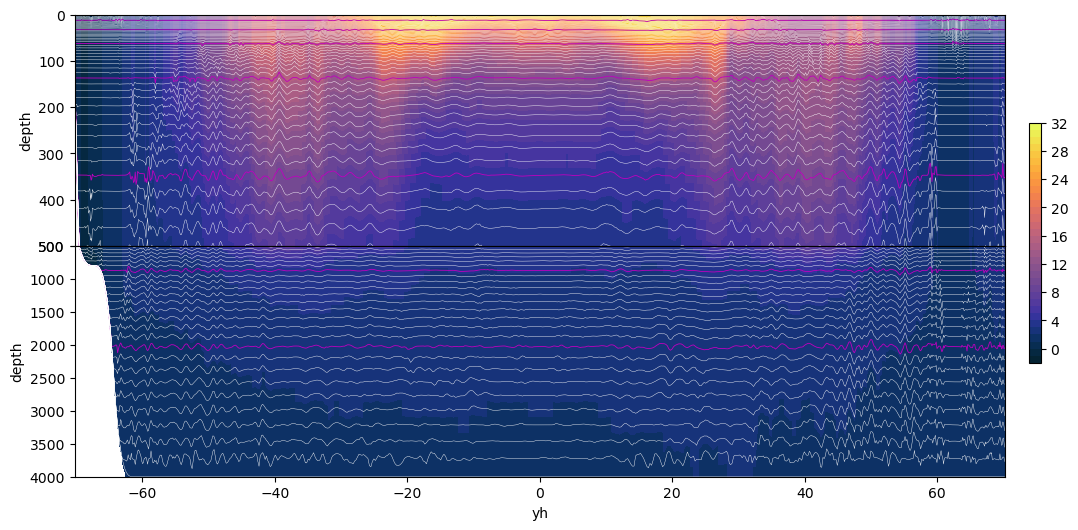

In [33]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))    
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal)

mean T gradient is 0.6373252750316906


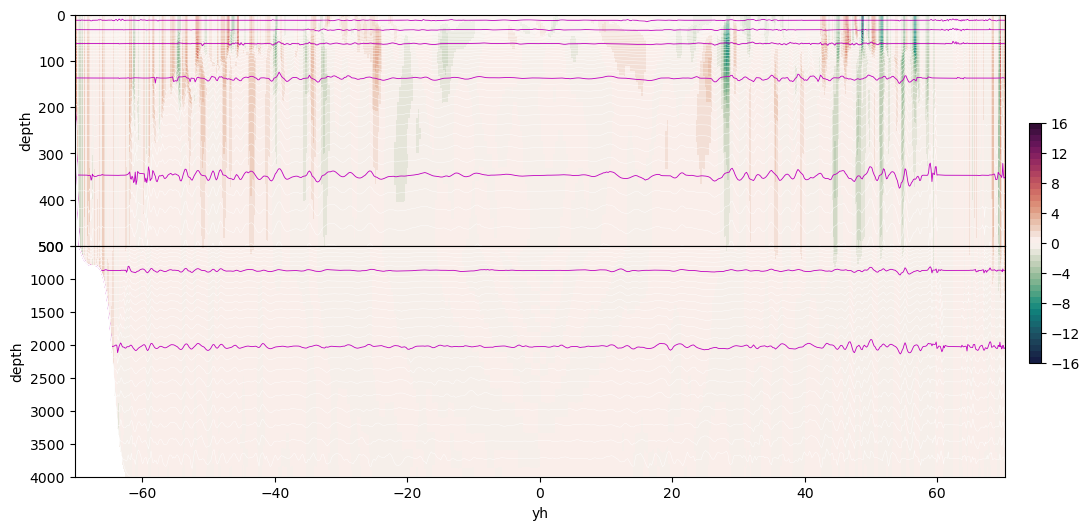

In [34]:
delT = new_temp.differentiate("yh")
tpplot(delT,h_depth,cmap=cm.cm.curl)
print("mean T gradient is", np.fabs(delT).mean().values) # should really weight this by cell volume

In [35]:
%%time
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "ADAPTIVE")
(h, temp, salt) = pyale.accelerate_ale(cs, adapt_cs, iter=2, dt=3600)

 init_MOM_state INPUTDIR: '/g/data/x77/amh157/mom6/input/anu-tub'
 init_MOM_state REGRIDDING_COORDINATE_UNITS: 'm'
 init_MOM_state INTERPOLATION_SCHEME: 'P1M_H2'
 init_MOM_state DEFAULT_2018_ANSWERS:  F
 init_MOM_state REMAPPING_2018_ANSWERS:  F
 init_MOM_state BOUNDARY_EXTRAPOLATION:  F
 init_MOM_state ALE_COORDINATE_CONFIG                   : 'FNC1:2,4000,4.5,.01'
 init_MOM_state !ALE_RESOLUTION                          :    2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0099999999999998        2.0099999999999998        2.0200000000000000        2.0299999999999998        2.0499999999999998        2.0800000000000001        2.1099999999999999        2.1499999999999999        2.2100000000000000        2.2800000000000002        2.3700000000000001        2.4800000000000000        2.6099999999999999        2.7700000000000000        2.9500000000000002     

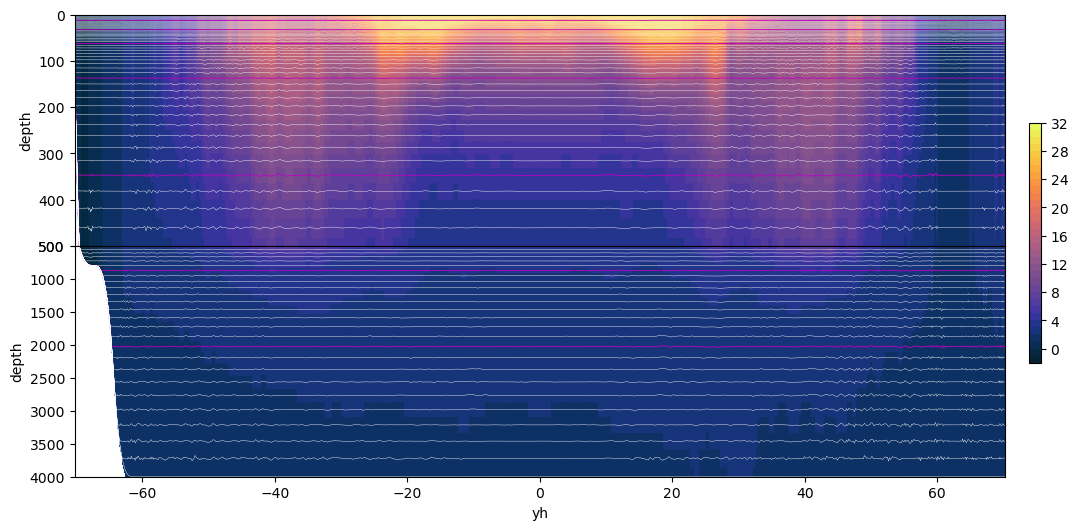

In [36]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))    
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal)

mean T gradient is 0.6735404305843657


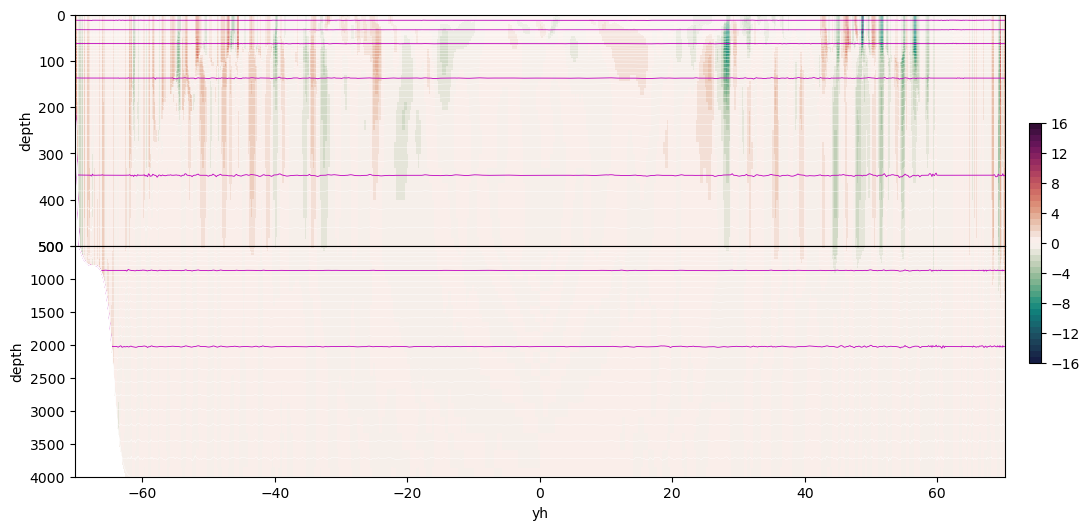

In [37]:
delT = new_temp.differentiate("yh")
tpplot(delT,h_depth,cmap=cm.cm.curl)
print("mean T gradient is", np.fabs(delT).mean().values) # should really weight this by cell volume

In [38]:
%%time
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "ADAPTIVE")
(h, temp, salt) = pyale.accelerate_ale(cs, adapt_cs, iter=100, dt=3600)

 init_MOM_state INPUTDIR: '/g/data/x77/amh157/mom6/input/anu-tub'
 init_MOM_state REGRIDDING_COORDINATE_UNITS: 'm'
 init_MOM_state INTERPOLATION_SCHEME: 'P1M_H2'
 init_MOM_state DEFAULT_2018_ANSWERS:  F
 init_MOM_state REMAPPING_2018_ANSWERS:  F
 init_MOM_state BOUNDARY_EXTRAPOLATION:  F
 init_MOM_state ALE_COORDINATE_CONFIG                   : 'FNC1:2,4000,4.5,.01'
 init_MOM_state !ALE_RESOLUTION                          :    2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0099999999999998        2.0099999999999998        2.0200000000000000        2.0299999999999998        2.0499999999999998        2.0800000000000001        2.1099999999999999        2.1499999999999999        2.2100000000000000        2.2800000000000002        2.3700000000000001        2.4800000000000000        2.6099999999999999        2.7700000000000000        2.9500000000000002     

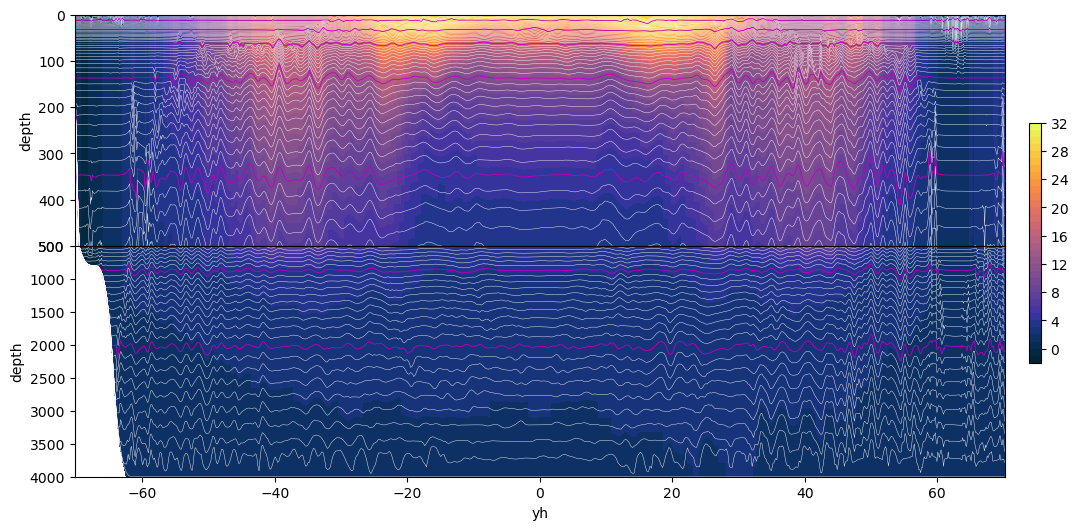

In [39]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))    
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal)

mean T gradient is 0.5957683817102085


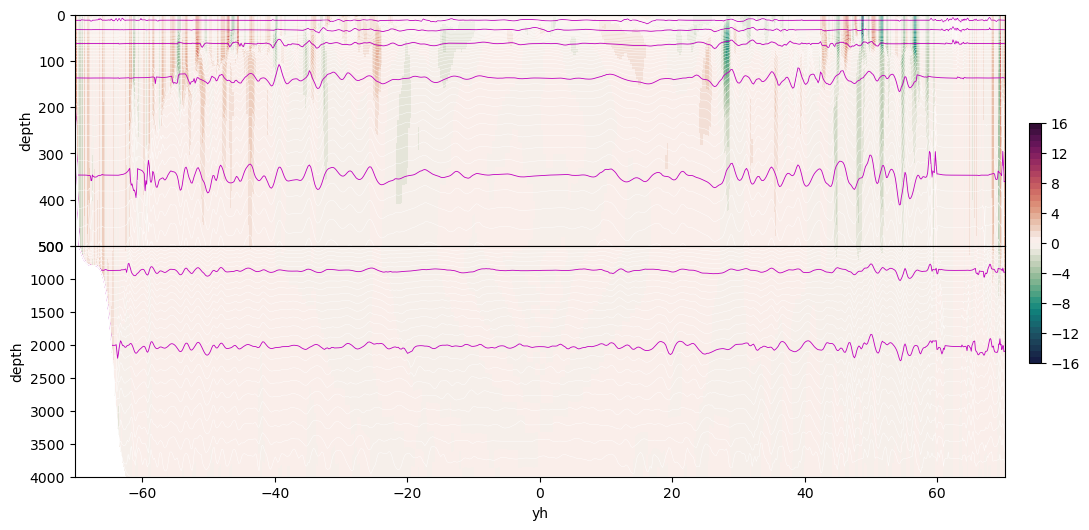

In [40]:
delT = new_temp.differentiate("yh")
tpplot(delT,h_depth,cmap=cm.cm.curl)
print("mean T gradient is", np.fabs(delT).mean().values) # should really weight this by cell volume

In [41]:
%%time
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "ADAPTIVE")
(h, temp, salt) = pyale.accelerate_ale(cs, adapt_cs, iter=300, dt=3600)

 init_MOM_state INPUTDIR: '/g/data/x77/amh157/mom6/input/anu-tub'
 init_MOM_state REGRIDDING_COORDINATE_UNITS: 'm'
 init_MOM_state INTERPOLATION_SCHEME: 'P1M_H2'
CPU times: user 32min 30s, sys: 2min 23s, total: 34min 54s
Wall time: 33min 28s
 init_MOM_state DEFAULT_2018_ANSWERS:  F
 init_MOM_state REMAPPING_2018_ANSWERS:  F
 init_MOM_state BOUNDARY_EXTRAPOLATION:  F
 init_MOM_state ALE_COORDINATE_CONFIG                   : 'FNC1:2,4000,4.5,.01'
 init_MOM_state !ALE_RESOLUTION                          :    2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0099999999999998        2.0099999999999998        2.0200000000000000        2.0299999999999998        2.0499999999999998        2.0800000000000001        2.1099999999999999        2.1499999999999999        2.2100000000000000        2.2800000000000002        2.3700000000000001        2.4800000000000000   

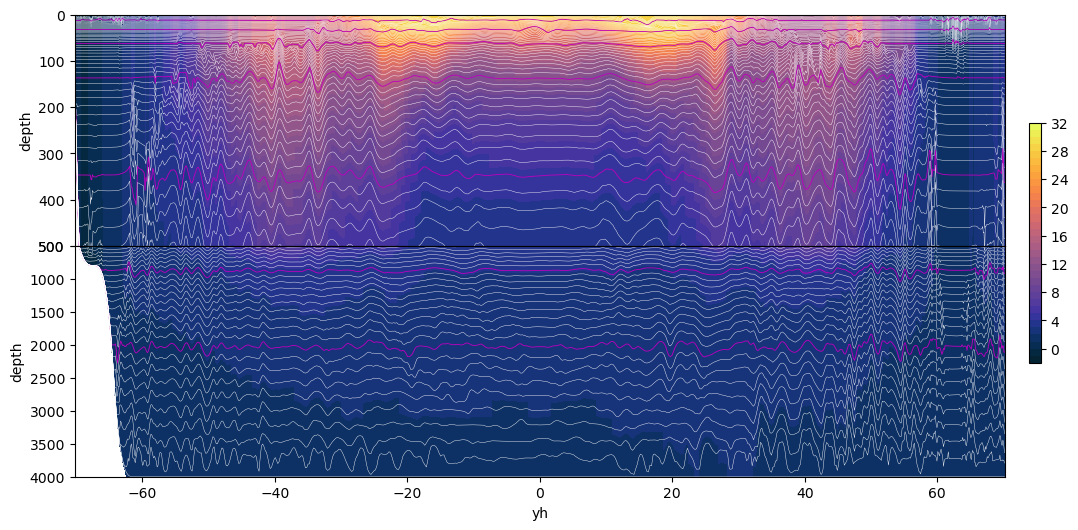

In [42]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))    
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal)

mean T gradient is 0.5799734534446278


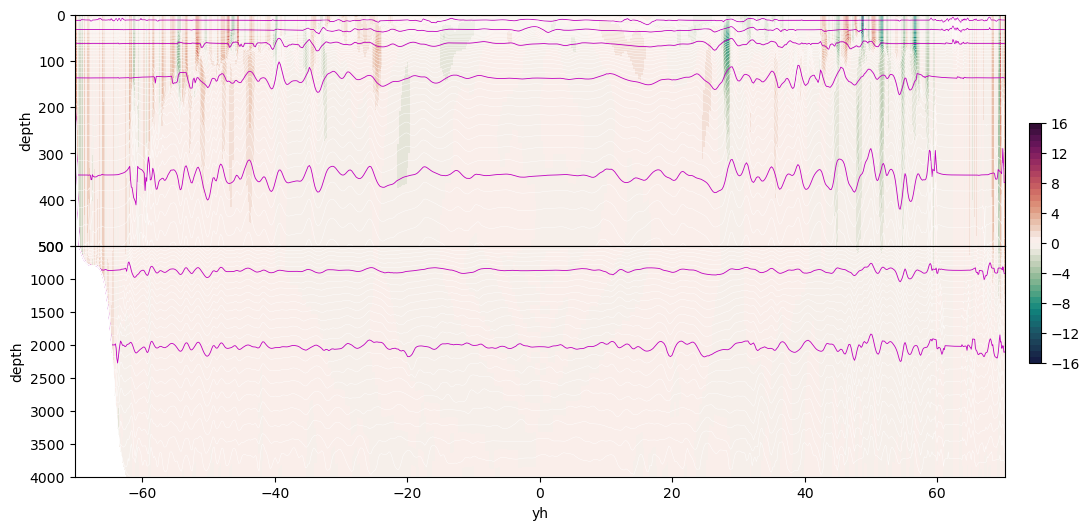

In [43]:
delT = new_temp.differentiate("yh")
tpplot(delT,h_depth,cmap=cm.cm.curl)
print("mean T gradient is", np.fabs(delT).mean().values) # should really weight this by cell volume

## Not sure what is going on here.

There doesn't seem to be any isopycnal adjustment going on here, but instead just a couple of spikes in layer thickness neear the continental shelf.

Also, the deepest layers is thickening, which is confusing.

I suspect there is a bug somewhere -- because this is different to the model output. WIll play with parameters to seach for it.

In [29]:
#params["ADAPT_TIMESCALE"] = 300.0             # was 3600
#params["REGRID_TIME_SCALE"] = 86400.0           # was 86400
#params["ADAPT_SMOOTH_MIN"] = 0.0             # was 0.1
#params["ADAPT_ADJUSTMENT_SCALE"] = 0.0        # was 0.1
params["ADAPT_TWIN_GRADIENT"] = True
params["ADAPT_PHYSICAL_SLOPE"] = True
params["ADAPT_SLOPE_CUTOFF"] = 0.0001
cs = pyale.mom_init_cs(params)

 log_version: MOM_domains                             , unknown
 MOM_domains                              REENTRANT_X:  F
 MOM_domains                              REENTRANT_Y:  F
 MOM_domains                              TRIPOLAR_N:  F
 MOM_domains                              !SYMMETRIC_MEMORY_:  T
 MOM_domains                              NONBLOCKING_UPDATES:  F
 MOM_domains                              THIN_HALO_UPDATES:  F
 MOM_domains                              !STATIC_MEMORY_:  F
 MOM_domains                              NIGLOBAL:          160
 MOM_domains                              NJGLOBAL:          800
 MOM_domains                              NIHALO:            4
 MOM_domains                              NJHALO:            4
 MOM_domains                              MASKTABLE: 'MOM_mask_table'
 MOM_domains                              NIPROC:            1
 MOM_domains                              NJPROC:            1
 MOM_domains                              LAYOUT:     

In [30]:
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "ADAPTIVE")

 init_MOM_state INPUTDIR: '/g/data/x77/amh157/mom6/input/anu-tub'
 init_MOM_state REGRIDDING_COORDINATE_UNITS: 'm'
 init_MOM_state INTERPOLATION_SCHEME: 'P1M_H2'
 init_MOM_state DEFAULT_2018_ANSWERS:  F
 init_MOM_state REMAPPING_2018_ANSWERS:  F
 init_MOM_state BOUNDARY_EXTRAPOLATION:  F
 init_MOM_state ALE_COORDINATE_CONFIG                   : 'FNC1:2,4000,4.5,.01'
 init_MOM_state !ALE_RESOLUTION                          :    2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0099999999999998        2.0099999999999998        2.0200000000000000        2.0299999999999998        2.0499999999999998        2.0800000000000001        2.1099999999999999        2.1499999999999999        2.2100000000000000        2.2800000000000002        2.3700000000000001        2.4800000000000000        2.6099999999999999        2.7700000000000000        2.9500000000000002     

In [37]:
(h, temp, salt) = pyale.accelerate_ale(cs, adapt_cs, iter=10, dt=3600)

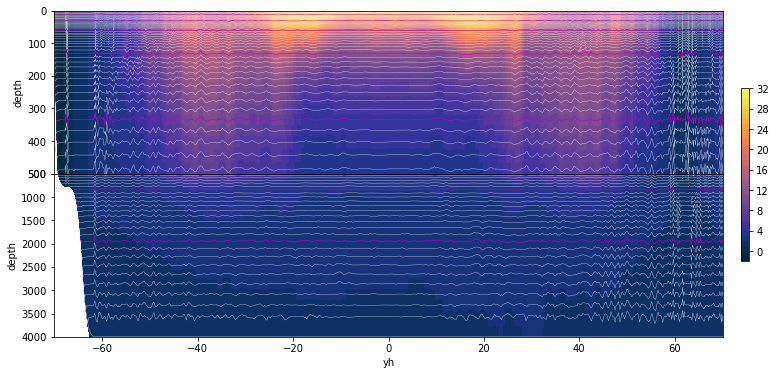

In [38]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))
            #attrs= u.attrs)
    
plt.figure(figsize=(12,6))
plt.subplot(211)
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cm.cm.thermal)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(ds2.lath.values,h_depth[:,ii],'m',linewidth=0.6)
    else:
        plt.plot(ds2.lath.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([0,500])
plt.gca().invert_yaxis()
    
plt.subplot(212)
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cm.cm.thermal)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(ds2.lath.values,h_depth[:,ii],'m',linewidth=0.6)
    else:
        plt.plot(ds2.lath.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([500,4000])
plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0)

ax_c = plt.axes([0.92,0.3,0.01,0.4])
plt.colorbar(p1,ax_c)

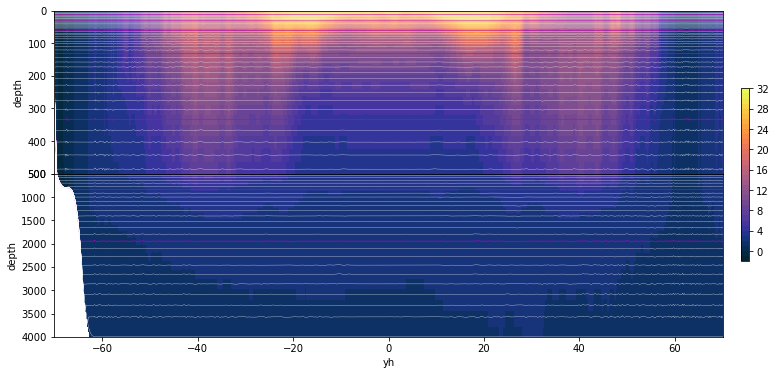

In [34]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))
            #attrs= u.attrs)
    
plt.figure(figsize=(12,6))
plt.subplot(211)
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cm.cm.thermal)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(ds2.lath.values,h_depth[:,ii],'m',linewidth=0.6)
    else:
        plt.plot(ds2.lath.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([0,500])
plt.gca().invert_yaxis()
    
plt.subplot(212)
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cm.cm.thermal)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(ds2.lath.values,h_depth[:,ii],'m',linewidth=0.6)
    else:
        plt.plot(ds2.lath.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([500,4000])
plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0)

ax_c = plt.axes([0.92,0.3,0.01,0.4])
plt.colorbar(p1,ax_c)

## Summary 

Parameter changes:
* `ADAPT_SMOOTH_MIN` seems to be creating the spikes at topography. At least, they disappear when I set that to zero.
* I don't understand why all these parameters are set to "F", even if I specifically set them to "T":
```    
 init_MOM_state ADAPT_MEAN_H:  F
 init_MOM_state ADAPT_TWIN_GRADIENT:  F
 init_MOM_state ADAPT_PHYSICAL_SLOPE:  F
 init_MOM_state ADAPT_RESTORE_MEAN:  F
 ```
* None of the other parameters seem to do anything.


In [17]:
!echo $OMP_NUM_THREADS

28


In [16]:
os.environ["OMP_NUM_THREADS"] = str(28)

In [15]:
import os